In [1]:
import sys
import celerite2.jax.terms as jax_terms
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import jax.numpy as jnp

from mind_the_gaps.gpmodelling import GPModelling, GPModellingComparison
from mind_the_gaps.lightcurves import GappyLightcurve
from mind_the_gaps.models.kernel_spec import (
    KernelParameterSpec,
    KernelSpec,
    KernelTermSpec,
)
from mind_the_gaps.simulator import Simulator
from scipy.stats import percentileofscore
from mind_the_gaps.models.psd_models import BendingPowerlaw, Lorentzian




celerite2.jax only works with dtype float64. We're enabling x64 now, but you might run into issues if you've already run some jax code.
You can squash this warning by setting the environment variable 'JAX_ENABLE_X64=True' or by running:
>>> from jax import config
>>> config.update('jax_enable_x64', True)
/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Case of No period

# Define parameters for lightcurve simulation

In [2]:
times  = np.arange(0, 1000)
dt = np.diff(times)[0]

mean = 100

#A = (mean * 0.1) ** 2 # variance of the lorentzian
#Q = 80
variance_drw = (mean * 0.1) ** 2  # variance of the DRW (bending powerlaw)
w_bend = 2 * np.pi / 20 # angular frequency of the DRW or Bending Powerlaw

# define the PSD model
psd_model = BendingPowerlaw(variance_drw, w_bend) 

# Simulate lightcurve

/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Text(0, 0.5, 'Rates (ct/s)')

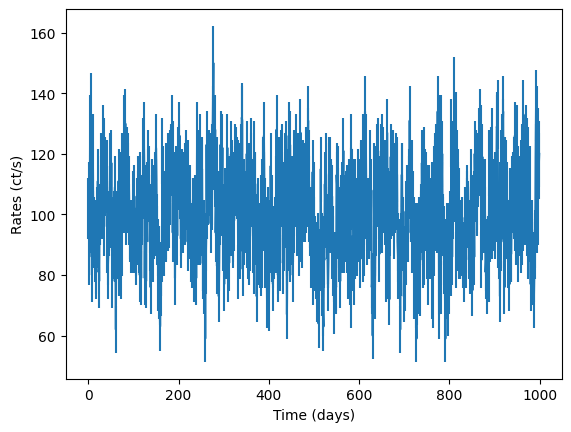

In [3]:
# create simulator object
simulator = Simulator(psd_model, times, np.ones(len(times)) * dt, mean, pdf="Gaussian", 
                     extension_factor=2)
# simulate noiseless count rates from the PSD, make the initial lightcurve 2 times as long as the original times
countrates = simulator.generate_lightcurve()
# add (Poisson) noise
noisy_countrates, dy = simulator.add_noise(countrates)

input_lc = GappyLightcurve(times, noisy_countrates, dy, exposures=dt)

fig = plt.figure()
plt.errorbar(times, noisy_countrates, yerr=dy)
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# Define null and alternative hypothesis

In [4]:
# null 
null_kernel_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=jax_terms.RealTerm,
                parameters={
                    "a": KernelParameterSpec(
                        value=jnp.log(variance_drw),
                        prior=dist.Uniform,
                        bounds=(-10, 50.0),
                    ),
                    "c": KernelParameterSpec(
                        value=jnp.log(w_bend),
                        prior=dist.Uniform,
                        bounds=(-10.0, 10.0),
                    ),
                },
            )
        ],
    )

P = 10 # period of the QPO
w = 2 * np.pi / P
# Define starting parameters
log_variance_qpo = np.log(variance_drw)
Q = 80 # coherence
log_c = np.log(0.5 * w/Q)
log_d = np.log(w)

alt_kernel_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=jax_terms.RealTerm,
                parameters={
                    "a": KernelParameterSpec(
                        value=jnp.log(variance_drw),
                        prior=dist.Uniform,
                        bounds=(-10, 50.0),
                    ),
                    "c": KernelParameterSpec(
                        value=jnp.log(w_bend),
                        prior=dist.Uniform,
                        bounds=(-10.0, 10.0),
                    ),
                },
            ),
            KernelTermSpec(
                term_class=jax_terms.ComplexTerm,
                parameters={
                    "a": KernelParameterSpec(
                        value=log_variance_qpo,
                        prior=dist.Uniform,
                        bounds=(-10, 50.0),
                    ),
                    "c": KernelParameterSpec(
                        value=log_c,
                        prior=dist.Uniform,
                        bounds=(-10, 10.0),
                    ),
                    "d": KernelParameterSpec(
                        value=log_d,
                        prior=dist.Uniform,
                        bounds=(-5.0, 5.0),
                    ),
                    "b": KernelParameterSpec(value=0.0, fixed=True),
                },
            ),
        ],
    )



# Set up GP Model Comparison

In [5]:

gp_model_comp = GPModellingComparison(
        null_kernel_spec=null_kernel_spec,
        alt_kernel_spec=alt_kernel_spec,
        lightcurve=input_lc,
        null_mean_params=jnp.array([input_lc.mean]),
        alt_mean_params=jnp.array([input_lc.mean]),
        fit_mean=True,
        meanmodel="constant",
    )

# Derive posteriors for both models lightcurves from null hypothesis posteriors

In [6]:
gp_model_comp.derive_posteriors(
        fit=True, max_steps=25000, num_chains=4, num_warmup=1000, converge_steps=500,  progress=False
    )

/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:133: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:146: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 500 steps.
MCMC not converged after 1000 steps.
MCMC not converged after 1500 steps.
MCMC not converged after 2000 steps.
MCMC not converged after 2500 steps.
MCMC not converged after 3000 steps.
MCMC not converged after 3500 steps.
MCMC not converged after 4000 steps.
MCMC not converged after 4500 steps.
MCMC not converged after 5000 steps.
MCMC converged after 5500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:133: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:146: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 500 steps.
MCMC not converged after 1000 steps.
MCMC not converged after 1500 steps.
MCMC not converged after 2000 steps.
MCMC not converged after 2500 steps.
MCMC not converged after 3000 steps.
MCMC not converged after 3500 steps.
MCMC not converged after 4000 steps.
MCMC not converged after 4500 steps.
MCMC not converged after 5000 steps.
MCMC not converged after 5500 steps.
MCMC not converged after 6000 steps.
MCMC not converged after 6500 steps.
MCMC not converged after 7000 steps.
MCMC not converged after 7500 steps.
MCMC not converged after 8000 steps.
MCMC not converged after 8500 steps.
MCMC not converged after 9000 steps.
MCMC not converged after 9500 steps.
MCMC not converged after 10000 steps.
MCMC not converged after 10500 steps.
MCMC not converged after 11000 steps.
MCMC not converged after 11500 steps.
MCMC not converged after 12000 steps.
MCMC not converged after 12500 steps.
MCMC not converged after 13000 steps.
MCMC not converged after 13500 s

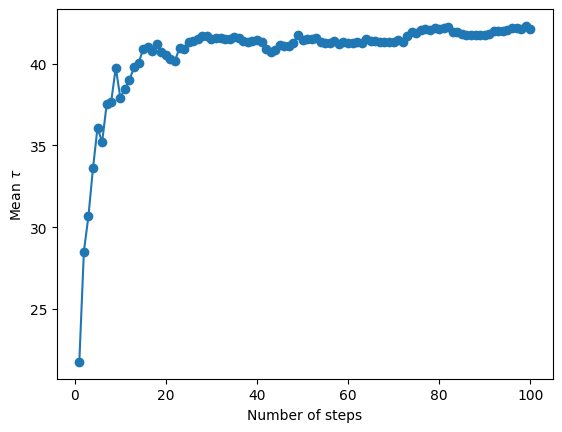

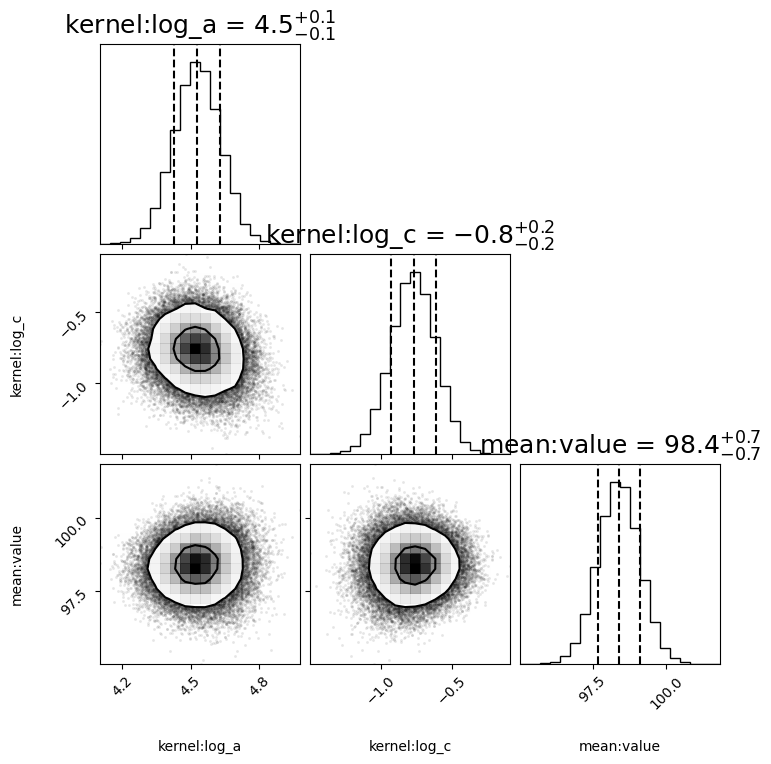

In [7]:
gp_model_comp.null_model.plot_autocorrelation()
gp_model_comp.null_model.corner_plot_samples()

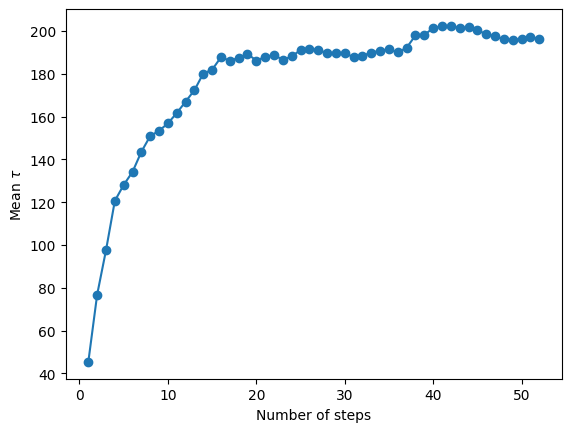

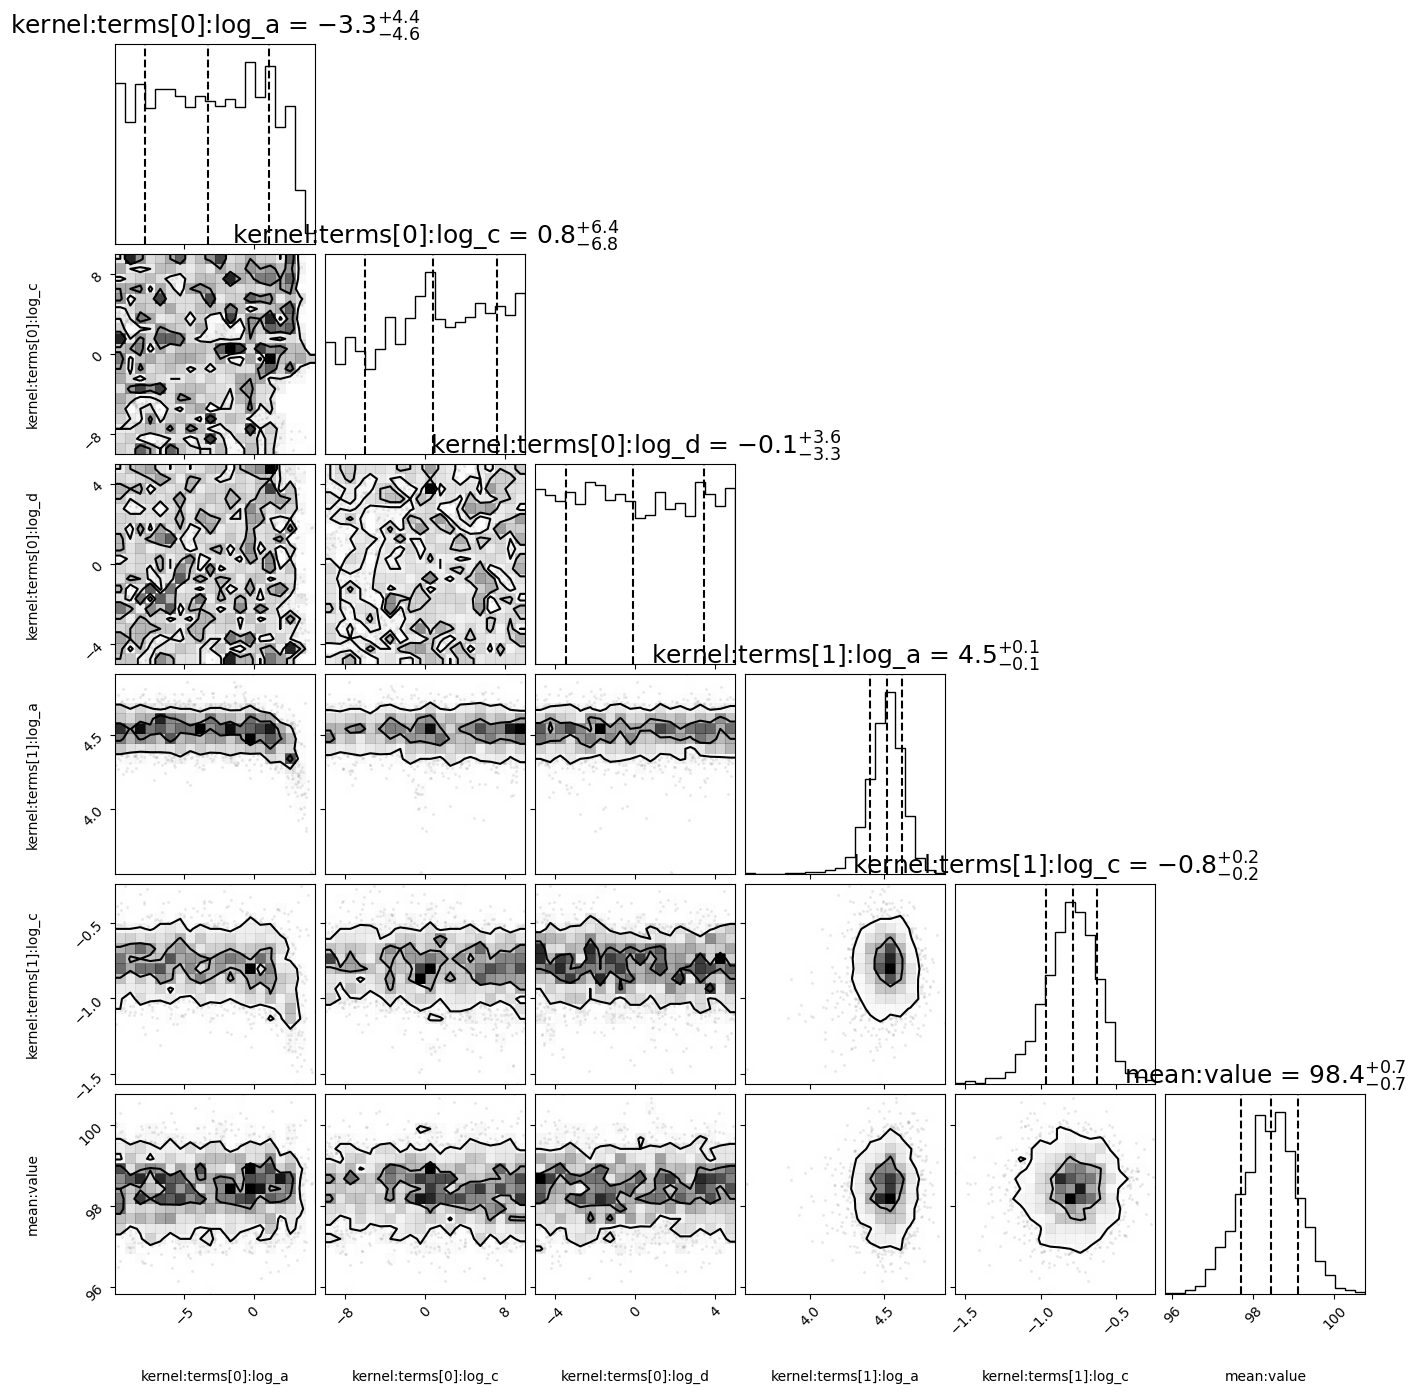

In [26]:
gp_model_comp.alt_model.plot_autocorrelation()
gp_model_comp.alt_model.corner_plot_samples()

# Generate lightcurves, and fit with both null and alternative models

In [ ]:
gp_model_comp.process_lightcurves(        nsims=10,
        fit=True,
        max_steps=500,
        num_chains=4,
        num_warmup=500,
        converge_steps=500)

/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Users/connorourke/

100%|██████████| 1000/1000 [00:03<00:00, 289.04it/s]


100%|██████████| 1000/1000 [00:03<00:00, 280.46it/s]


100%|██████████| 1000/1000 [00:03<00:00, 305.17it/s]


100%|██████████| 1000/1000 [00:03<00:00, 312.04it/s]


100%|██████████| 1000/1000 [00:03<00:00, 286.14it/s]


KeyboardInterrupt: 

# Perform Likelihood Ratio Test

In [ ]:
gp_model_comp.likelihood_ratio_test(path="LRT_no_period.png")

We see the p-value to reject the null hypothesis is fairly low, indicating there is no signal in this data, as expected

# Case with Period

# Simulate lightcurve

In [28]:
times  = np.arange(0, 500)
dt = np.diff(times)[0]

mean = 100

P = 10 # period of the QPO
w_qpo = 2 * np.pi / P
w_bend = 2 * np.pi / 20 # angular frequency of the DRW or Bending Powerlaw
# Define starting parameters
variance_drw = (mean * 0.1) ** 2  # variance of the DRW (bending powerlaw)
variance_qpo = variance_drw # let's assume same variance for the QPO and the DRW

Q = 80 # coherence

psd_model = Lorentzian(variance_qpo, Q, w_qpo) + BendingPowerlaw(variance_drw, w_bend) 

Text(0, 0.5, 'Rates (ct/s)')

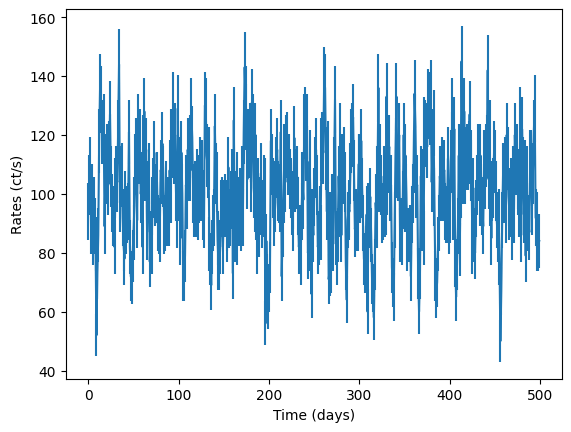

In [29]:
simulator = Simulator(psd_model, times, np.ones(len(times)) * dt, mean, pdf="Gaussian", max_iter=500)

rates = simulator.generate_lightcurve()
noisy_rates, dy = simulator.add_noise(rates)

input_lc = GappyLightcurve(times, noisy_rates, dy, exposures=dt)

fig = plt.figure()
plt.errorbar(times, noisy_rates, yerr=dy)
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# Define null hypothesis

In [ ]:

null_kernel_spec =  KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=jax_terms.RealTerm,
                parameters={
                    "a": KernelParameterSpec(
                        value=jnp.log(variance_drw),
                        prior=dist.Uniform,
                        bounds=(-10, 50.0),
                    ),
                    "c": KernelParameterSpec(
                        value=jnp.log(w_bend),
                        prior=dist.Uniform,
                        bounds=(-10.0, 10.0),
                    ),
                },
            )
        ],
    )



# Define alternative model

In [ ]:
log_c = np.log(0.5 * w_qpo/Q)
log_d = np.log(w_qpo)
bounds_qpo = dict(log_a=(-10, 50), log_c=(-10, 10), log_d=(-5, 5))
# again you may use the Lorentzian from models.celerite_models

alternative_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=jax_terms.ComplexTerm,
                parameters={
"a": KernelParameterSpec(
                        value=log_variance_qpo,
                        prior=dist.Uniform,
                        bounds=(-10, 50.0),
                    ),
                    "c": KernelParameterSpec(
                        value=log_c,
                        prior=dist.Uniform,
                        bounds=(-10, 10.0),
                    ),
                    "d": KernelParameterSpec(
                        value=log_d,
                        prior=dist.Uniform,
                        bounds=(-5.0, 5.0),
                    ),
                    "b": KernelParameterSpec(value=0.0, fixed=True),
                },
            ),
            KernelTermSpec(
                term_class=jax_terms.RealTerm,
                parameters={
                    "a": KernelParameterSpec(
                        value=jnp.log(variance_drw),
                        prior=dist.Uniform,
                        bounds=(-10, 50.0),
                    ),
                    "c": KernelParameterSpec(
                        value=jnp.log(w_bend),
                        prior=dist.Uniform,
                        bounds=(-10.0, 10.0),
                    ),
                },
            ),
        ],
    )




# Set up GP Model Comparison

In [32]:
comparison_kwargs = {
        "null_kwargs": {
            "fit_mean": True,
            "cpus": 10,
        },
        "alt_kwargs": {
            "fit_mean": True,
            "cpus": 10,
        },
    }
gp_model_comp = GPModellingComparison(
        null_kernel_spec=null_spec,
        alt_kernel_spec=alternative_spec,
        lightcurve=input_lc,
        **comparison_kwargs,
    )

# Derive Posteriors for null and alternative models

In [ ]:
gp_model_comp.derive_posteriors(fit=True, max_steps=50000, cores=10)

 20%|██        | 10000/50000 [00:23<01:34, 423.57it/s]


Convergence reached after 10000 samples!


 25%|██▌       | 12500/50000 [00:41<02:04, 301.65it/s]


Convergence reached after 12500 samples!


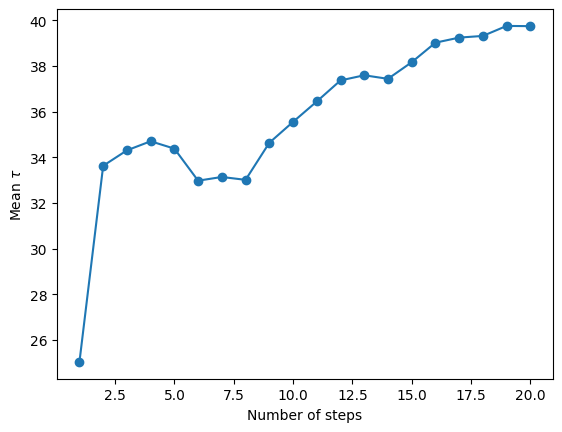

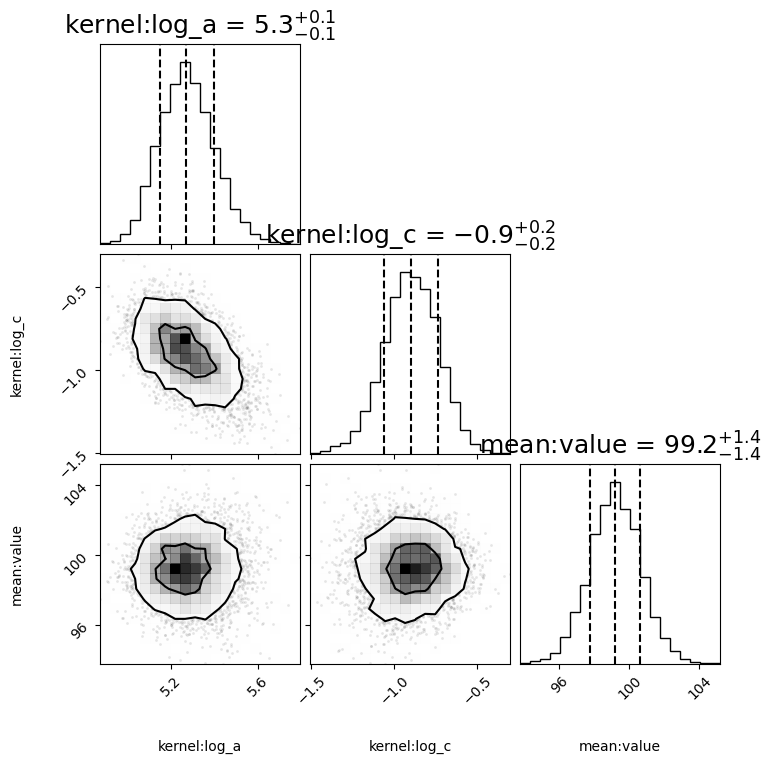

In [34]:
gp_model_comp.null_model.plot_autocorrelation()
gp_model_comp.null_model.corner_plot_samples()

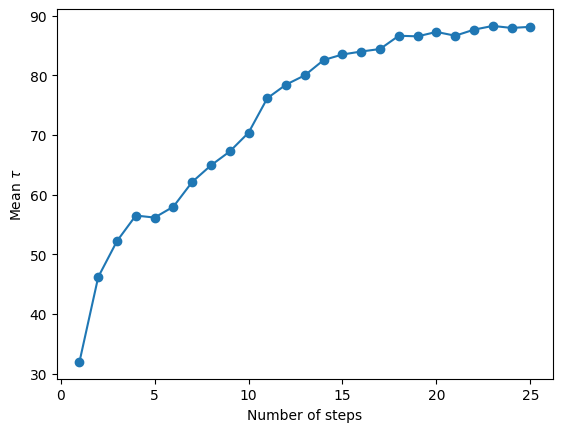

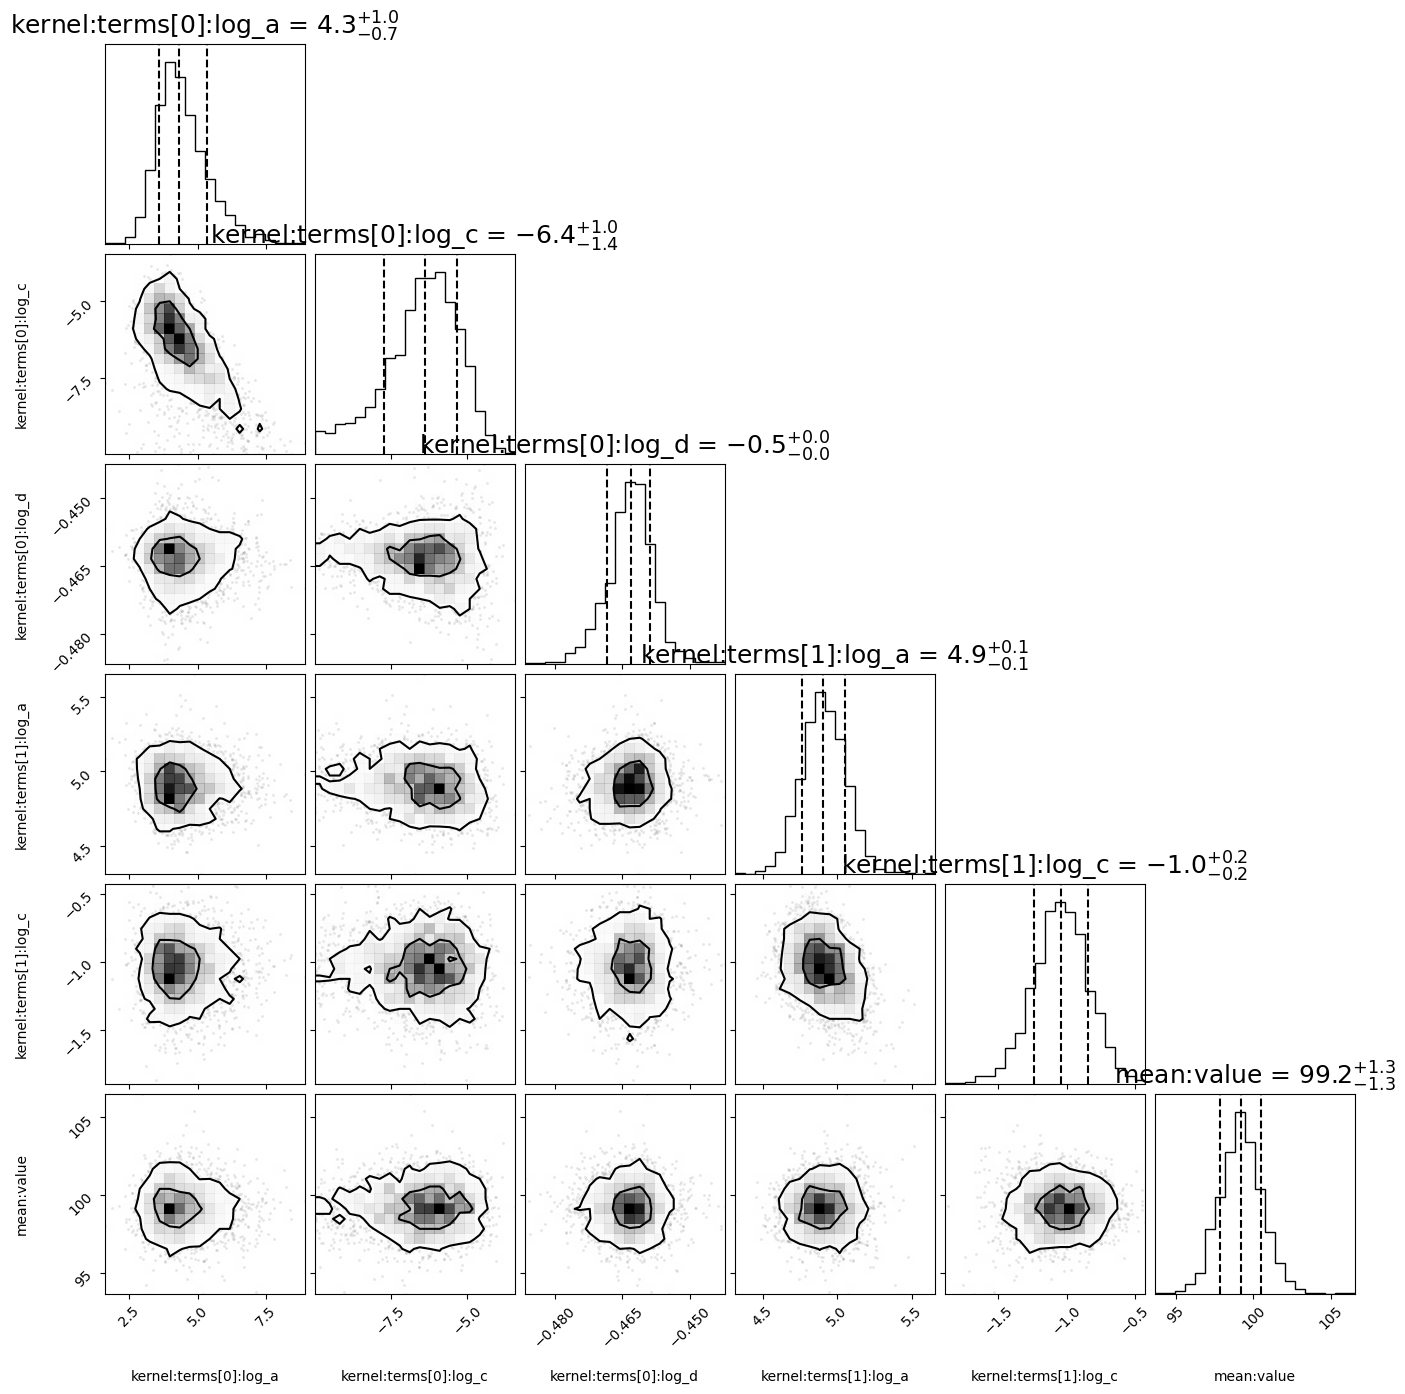

In [35]:
gp_model_comp.alt_model.plot_autocorrelation()
gp_model_comp.alt_model.corner_plot_samples()

# Generate lightcurves, and fit with both null and alternative models

In [ ]:
gp_model_comp.process_lightcurves_par(nsims=100, fit=True, max_steps=1000, par_workers=10)

# Perform Likelihood Ratio Test

In [ ]:
gp_model_comp.likelihood_ratio_test(path="LRT_no_period.png")